In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json

2024-10-16 15:40:59.846993: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 15:40:59.875575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 15:41:00.378901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### importing libraries

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import skimage.transform
from skimage import io
from sklearn.preprocessing import OneHotEncoder
import joblib

import tensorflow as tf

#### Selecting Gestures

In [3]:
gesture_list = ['Swiping Right','Swiping Left','Thumb Up','Thumb Down','No gesture','Zooming In With Full Hand','Zooming Out With Full Hand']

#train
file_prefix = "new_jester_3DCNN"
df = pd.read_csv('./annotations/jester-v1-train.csv',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_train.csv'.format(file_prefix),sep=';',index=False)
# pd.read_csv('jester-v1-8classes_train.csv',sep=";").head()
print(df.shape)
print(df.head())
#val
df = pd.read_csv('./annotations/jester-v1-validation.csv',sep=';',header=None,names=['id','labels'])
df = df[df['labels'].isin(gesture_list)]
df.to_csv('{}_val.csv'.format(file_prefix),sep=';',index=False)
print(df.shape)
print(df.head())

print('Csvs done')

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size=2, image_dim=(256,256), frames_count=36, n_channels=1, base_dir='./20bn-jester-v1/', n_classes=27,validation=False):
        self.image_dim = image_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = True 
        self.frames_count = frames_count
        self.df = pd.read_csv(file_path,sep=";")
        self.df.id = self.df.id.map(str)
        if "train" in file_path:
            self.encoder = OneHotEncoder(sparse=False)
            self.encoder.fit(self.df.labels.values[:,None])
            joblib.dump(self.encoder,"{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
            np.save("encoder_classes_{}_npy.npy".format(n_classes),self.encoder.categories_)
        else:
            self.encoder = joblib.load("{}_encoder_joblib.joblib".format('_'.join(file_path.split('_')[:-1])))
        self.base_dir = base_dir
        self.on_epoch_end()

    def __len__(self):
        ## Decides step_size
        return self.df.shape[0] // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = self.df.loc[indexes,"id"].to_list()
        X, y = self.__data_generation(indexes)
        return X, y 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.df.shape[0])
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size,self.frames_count, *self.image_dim, self.n_channels))
        y = np.empty((self.batch_size,1), dtype=str)
        y = []
        for i, ID in enumerate(indexes):
            files_list = self.standardize_frame_count(glob(self.base_dir + self.df.loc[ID,"id"] + "/*.jpg"),self.df.loc[ID])
            for idx,filename in enumerate(files_list):
                X[i,idx] = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(filename,color_mode='grayscale',target_size=self.image_dim))
            y.append(self.df.loc[ID,"labels"])
        encoded = self.encoder.transform(np.array(y)[:,None])
        return X,encoded
        
    def standardize_frame_count(self,files,error_check):
        shape = len(files)
        if shape < self.frames_count:
            to_add = self.frames_count - shape
            mid  = len(files)//2
            dup = [files[mid]]*to_add
            files = files[:mid] + dup + files[mid+1:]
        elif shape > self.frames_count:
            to_remove = (shape - self.frames_count)
            to_remove = int(to_remove) if int(to_remove) == to_remove else int(to_remove) + 1
            files = files[to_remove:]
        return files
    
params = {'batch_size': 56,
          'n_classes': len(gesture_list),
          'n_channels': 3,
          'image_dim': (32,32)
          }

# Generators
training_generator = DataGenerator(file_path="{}_train.csv".format(file_prefix),**params)
validation_generator = DataGenerator(file_path="{}_val.csv".format(file_prefix),**params)


(29819, 2)
        id                      labels
7   136859                    Thumb Up
8    68574               Swiping Right
13   20706                  No gesture
14   42237                  Thumb Down
19  133442  Zooming Out With Full Hand
(3640, 2)
       id                     labels
0    9223                   Thumb Up
2   42920               Swiping Left
3  106485                 Thumb Down
6   35341  Zooming In With Full Hand
7   94928              Swiping Right
Csvs done


/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPool3D, Dense, Flatten, Dropout, ConvLSTM2D, LSTM
from tensorflow.keras.models import model_from_json
#from keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

In [6]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti, compute capability 7.5


2024-10-16 15:41:08.198520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 15:41:08.217804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 15:41:08.217984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
input_shape = (36, 32, 32, 3)

ELU(x)={ 
x if x>0
α(e 
x
 −1)
if x≤0
}

For positive inputs, the ELU behaves like the identity function (i.e., ELU(x) = x), similar to ReLU.
For negative inputs, ELU produces a smooth exponential curve. This makes it differentiable across the entire domain, unlike ReLU which has a discontinuity at zero.

Avoids "dead neurons": Unlike ReLU, which can become inactive (outputting zero) for all inputs after a certain point (known as the "dying ReLU problem"), ELU has non-zero output for negative inputs, avoiding dead neurons.


In [8]:
def build_model(n_classes=7):
    momentum = 0.99
    
    model = tf.keras.Sequential()
    model.add(Conv3D(64,kernel_size=3,strides=1,padding='valid',activation='elu',input_shape=input_shape))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1,2,2),padding='same'))

    model.add(Conv3D(128,kernel_size=3,strides=1,padding='valid',activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2,2,2),padding='same'))

    model.add(Conv3D(256,kernel_size=3,strides=1,padding='valid',activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2,2,2),padding='same'))

    model.add(Conv3D(256,kernel_size=3,strides=1,padding='valid',activation='elu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool3D(pool_size=(2, 2, 2), strides=(2,2,2),padding='same'))
    
    model.add(Flatten())

    model.add(Dense(512,activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes,activation='softmax'))
    #batch_size,n_classes
    return model

model = build_model(n_classes=len(gesture_list))
optimizer = SGD(0.001)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

h=model.fit(training_generator,validation_data=validation_generator,validation_steps=32,epochs=20,verbose=1)

def save_model(model,file_path):
    model_json = model.to_json()
    with open(file_path+'.json', "w") as json_file:
        json_file.write(model_json)
    model.save_weights(file_path+'.h5')
save_model(model,'{}_model'.format(file_prefix))



2024-10-16 15:41:10.531782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 15:41:10.531981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 15:41:10.532109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/20


/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-10-16 15:41:12.922000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


  1/532 [..............................] - ETA: 9:18:16 - loss: 3.1543 - accuracy: 0.1250

2024-10-16 15:42:14.832523: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f3a9170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-16 15:42:14.832545: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-16 15:42:14.872281: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


532/532 [==============================] - ETA: 0s - loss: 1.6253 - accuracy: 0.4626

/home/mca/anaconda3/envs/dse/lib/python3.8/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


532/532 [==============================] - 241s 335ms/step - loss: 1.6253 - accuracy: 0.4626 - val_loss: 1.0085 - val_accuracy: 0.6233
Epoch 2/20
532/532 [==============================] - 174s 326ms/step - loss: 1.0285 - accuracy: 0.6343 - val_loss: 0.8243 - val_accuracy: 0.6959
Epoch 3/20
532/532 [==============================] - 179s 336ms/step - loss: 0.8296 - accuracy: 0.7048 - val_loss: 0.7324 - val_accuracy: 0.7427
Epoch 4/20
532/532 [==============================] - 178s 335ms/step - loss: 0.7107 - accuracy: 0.7445 - val_loss: 0.6370 - val_accuracy: 0.7796
Epoch 5/20
532/532 [==============================] - 177s 332ms/step - loss: 0.6225 - accuracy: 0.7829 - val_loss: 0.5476 - val_accuracy: 0.8047
Epoch 6/20
532/532 [==============================] - 180s 338ms/step - loss: 0.5529 - accuracy: 0.8047 - val_loss: 0.5451 - val_accuracy: 0.8069
Epoch 7/20
532/532 [==============================] - 180s 339ms/step - loss: 0.5007 - accuracy: 0.8231 - val_loss: 0.5906 - val_accura

### issue fixed
ISSUE: `val loss` was becoming `nan`, after 13th epoch.

- Possible fixes:
a small number (like 1e-8) to your output probability.
u can either make a customized loss fuction with an added epsilon value, or `loss=CategoricalCrossentropy(from_logits=True)`

- (Because log(0) is negative infinity, when your model trained enough the output distribution will be very skewed, for instance say I'm doing a 4 class output, in the beginning my probability looks like

0.25 0.25 0.25 0.25
but toward the end the probability will probably look like

1.0 0 0 0
And you take a cross entropy of this distribution everything will explode. The fix is to artifitially add a small number to all the terms to prevent this. The gradients cant be computed, divide by 0 err may occur, keras makes the value nan in such cases.


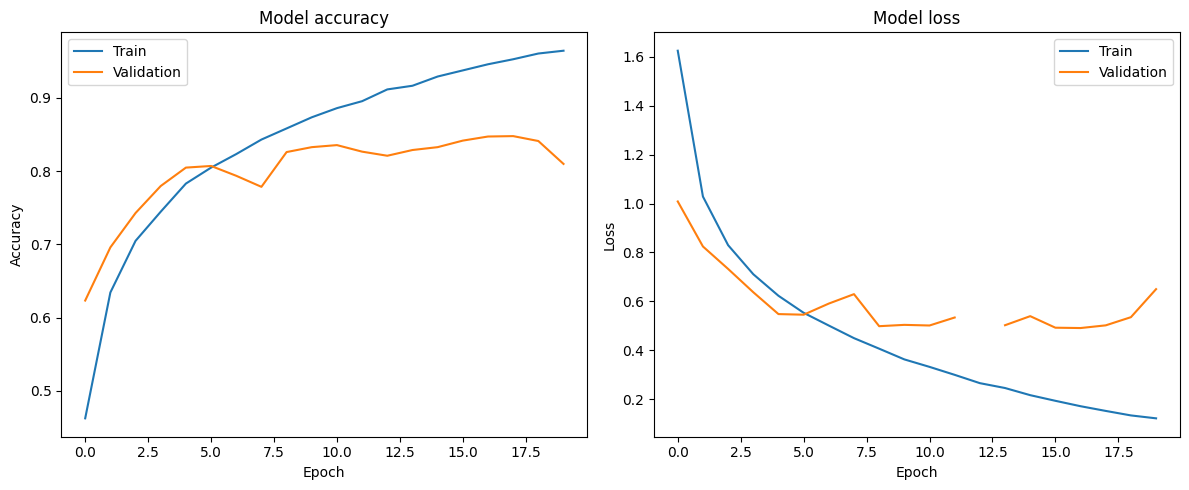

In [10]:
import matplotlib.pyplot as plt  

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()


In [13]:
model.evaluate(validation_generator)

65/65 [==============================] - 20s 304ms/step - loss: 0.6116 - accuracy: 0.8170


[0.6115515828132629, 0.8170329928398132]